In [229]:
from enum import Enum
import cv2
from matplotlib import pyplot as plt
import numpy as np
import json

In [230]:
INPUT_DIR = "./data/input/test.jpg"
LABEL_JSON = "./data/label.json"
OUTPUT_DIR = "./data/output"

class Field:
    def __init__(self, img: np.ndarray, rect: tuple[int, int, int, int] = (0, 0, 0, 0)):
        self.img = img
        self.rect = rect

    def __repr__(self):
        return f"{self.rect} -> {self.img}"


class FieldName(Enum):
    exam_title = "exam_title"
    student_name = "student_name"
    date = "date"
    exam_key = "exam_key"
    student_id = "student_id"
    answers = "answers"
    


In [231]:
def load_image(image_path):
    return cv2.imread(image_path)

def show_image(image, title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def save_image(image, image_name, output_dir=OUTPUT_DIR):
    cv2.imwrite(f"{output_dir}/{image_name}", image)

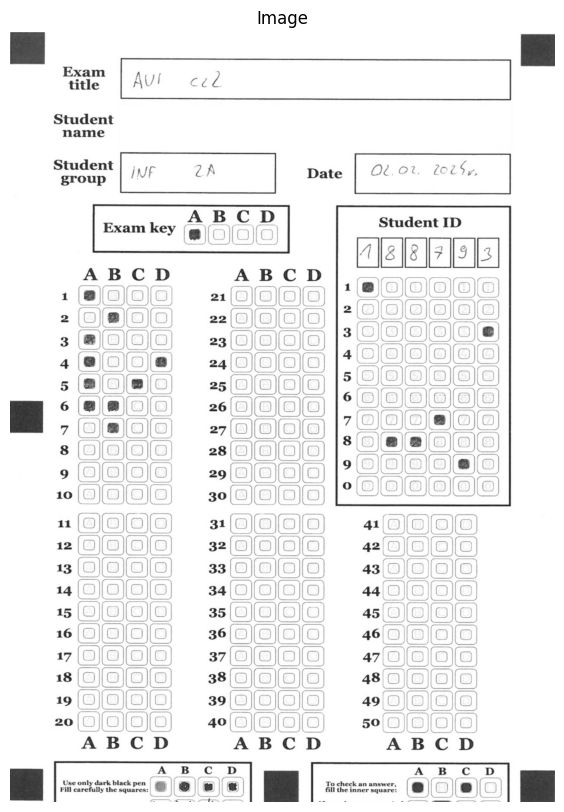

In [232]:
image = load_image(INPUT_DIR)
show_image(image)


In [233]:
def load_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)

def map_json_to_field_coordinates(json_data):
    field_coordinates = {}
    for field, coordinates_list in json_data["fields"].items():
        if field in FieldName.__members__:
            field_enum = FieldName[field]
            field_coordinates[field_enum] = [
                (coord["x"], coord["y"], coord["width"], coord["height"]) for coord in coordinates_list
            ]
    return field_coordinates


json_data = load_json(LABEL_JSON)
FIELD_COORDINATES = map_json_to_field_coordinates(json_data)
FIELD_COORDINATES

{<FieldName.answers: 'answers'>: [(305, 1150, 440, 1010),
  (305, 2185, 440, 1010),
  (998, 1150, 440, 1010),
  (998, 2185, 440, 1010),
  (1690, 2190, 440, 1010)]}

In [234]:

def crop_image(image, coordinates):
    x, y, w, h = coordinates
    print(f"X: {x}, Y: {y}, W: {w}, H: {h}")
    return image[y:y+h, x:x+w]

def extract_fields_from_coordinates(image, field_coordinates):
    fields = {}
    for field_name, coordinates in field_coordinates.items():
        for i, coordinate in enumerate(coordinates):
            field_image = crop_image(image, coordinate)
            fields[f"{field_name}_{i}"] = field_image
            
    return fields

fields = extract_fields_from_coordinates(image, FIELD_COORDINATES)

X: 305, Y: 1150, W: 440, H: 1010
X: 305, Y: 2185, W: 440, H: 1010
X: 998, Y: 1150, W: 440, H: 1010
X: 998, Y: 2185, W: 440, H: 1010
X: 1690, Y: 2190, W: 440, H: 1010


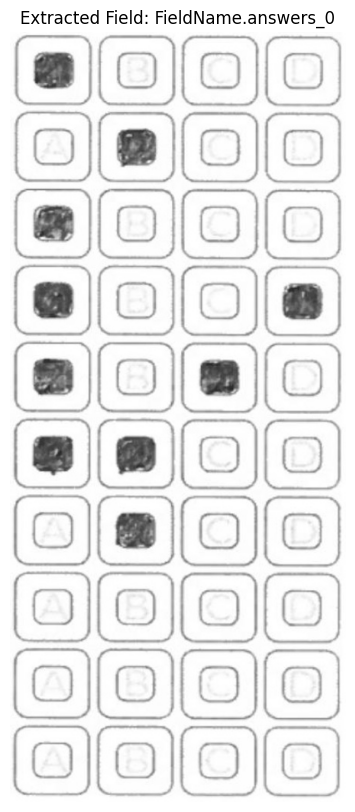

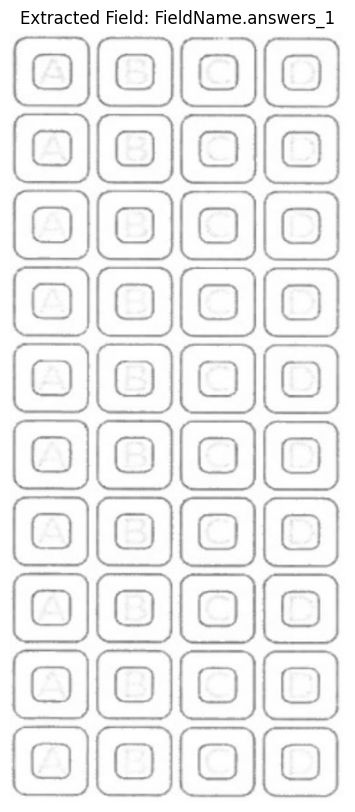

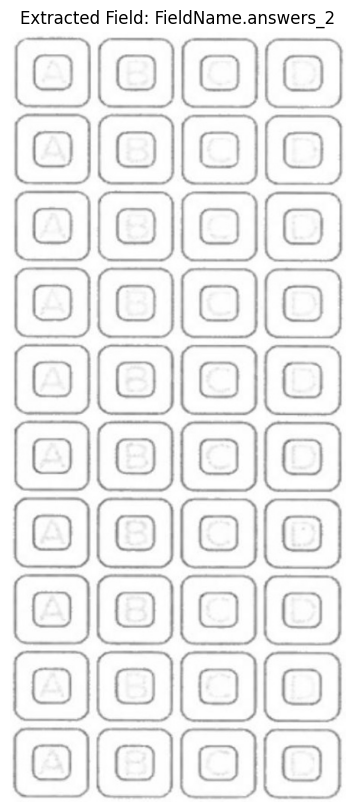

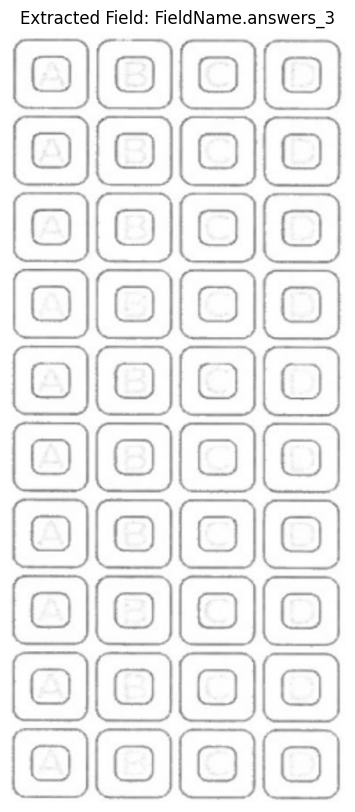

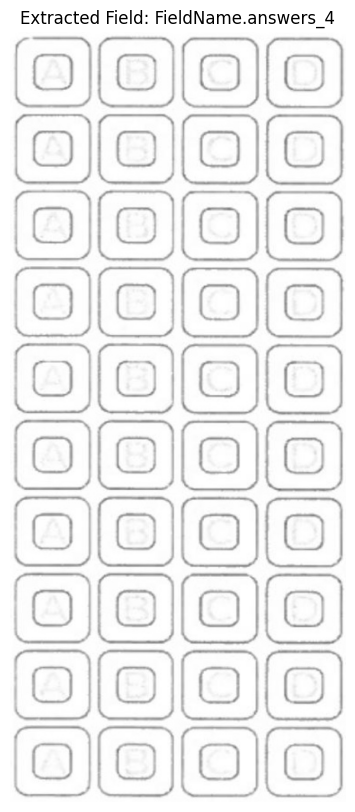

In [235]:
for field_name, field_image in fields.items():
    show_image(field_image, f"Extracted Field: {field_name}")
    save_image(field_image, f"{field_name}.jpg")